In [2]:
import rioxarray as rxr
import matplotlib.pyplot as plt
import geopandas as gpd
import numpy as np
import glob
import os
import pandas as pd
import xarray as xr
from rasterio.enums import Resampling
from scipy.signal import convolve2d

In [3]:
name = 'COPP'
BS = f'/home/etboud/projects/data/basins/{name}/{name}_4326.geojson'
# utm_epsg = 'EPSG:32611'
utm_epsg = 'EPSG:26913'
basin = gpd.read_file(BS).to_crs(utm_epsg)

(1, 2240, 2373)


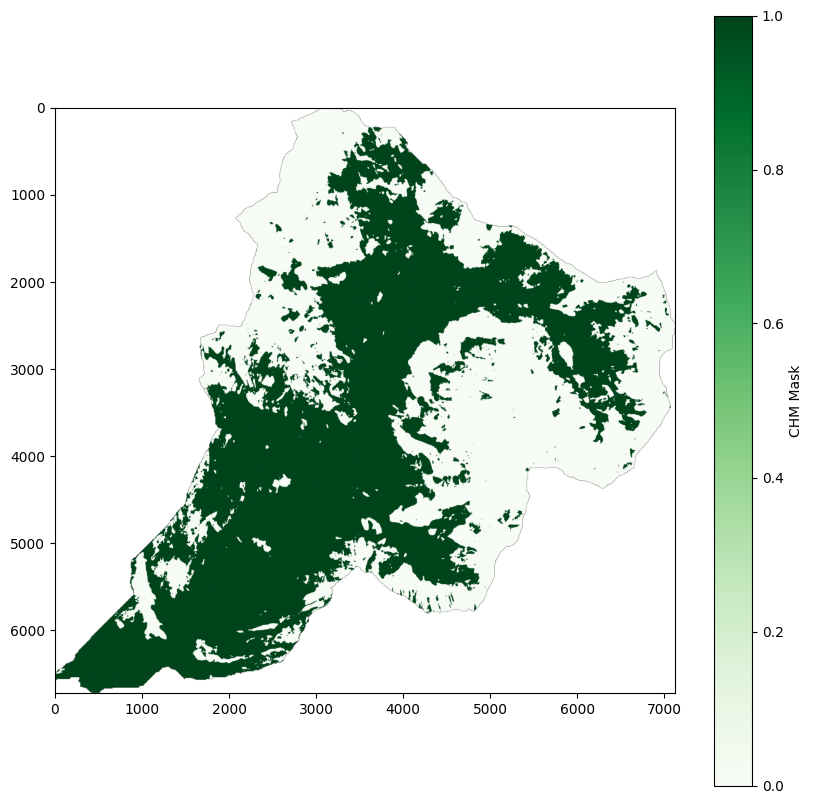

In [16]:

# chm_mask = rxr.open_rasterio('/home/etboud/projects/data/CHM/USCATB20140827_chm_3p0m.tif', all_touched=False,drop=True, masked=True).rio.clip(basin.geometry.values, all_touched = False,  drop=True)
# chm_mask.values = np.where(chm_mask < 2, 0, chm_mask) 
# chm_mask.values = np.where(chm_mask > 2, 1, chm_mask) 
chm_mask = rxr.open_rasterio(f'/home/etboud/projects/data/masks/4b_15img_ndvi_30_85_{name}_notclipped.tif',masked =False).rio.clip(basin.geometry.values, all_touched = False,  drop=True)

basin_mask = rxr.open_rasterio(f'/home/etboud/projects/data/masks/{name}_mask.tif', masked=True).rio.clip(basin.geometry.values, all_touched = False,  drop=True)
print(basin_mask.shape)
chm_mask.rio.set_nodata(np.nan, inplace=True)
chm_mask = chm_mask.rio.clip(basin.geometry.values, all_touched = False,  drop=True)
chm_mask.values = np.where(chm_mask.values > 0, 1.0, 0.0)  # Ensure float type for handling NaN
chm_mask.values = np.where(basin_mask == 1, chm_mask, np.nan)  # Apply basin mask
chm_mask = chm_mask.rio.reproject(utm_epsg, resolution=1.0, resampling=Resampling.mode)
opnclass = -chm_mask.values
canclass = chm_mask.values-1

ingrid_opn = chm_mask.values
ingrid_can = -(chm_mask.values-1)
ingrid_opn = ingrid_opn[0]
ingrid_can = ingrid_can[0]
#plot chm_mask
plt.figure(figsize=(10, 10))
plt.imshow(chm_mask[0], cmap='Greens', vmin=0, vmax=1)
plt.colorbar(label='CHM Mask')




In [ ]:
basin_mask = rxr.open_rasterio(f'/home/etboud/projects/data/masks/{name}_mask.tif')

In [5]:
def create_circular_kernel(radius):
    """Create a circular kernel of specified radius."""
    size = 2 * radius + 1
    kernel = np.zeros((size, size), dtype=np.float32)
    center = radius

    for x in range(size):
        for y in range(size):
            if np.sqrt((x - center) ** 2 + (y - center) ** 2) <= radius:
                kernel[x, y] = 1

    return kernel

kernel = create_circular_kernel(1)

In [6]:
step_nr = 350

In [18]:
basin_mask.shape

(1, 2240, 2373)

In [ ]:

from scipy.ndimage import convolve

# Ensure the kernel is defined
kernel = create_circular_kernel(1)

for ssx in range(1, step_nr + 1):
    chmsm_opn = convolve(ingrid_opn, kernel, mode='constant', cval=0)
    chmsm_can = convolve(ingrid_can, kernel, mode='constant', cval=0)

    # detect edges
    # opn_update_mask = (opnclass == 0) & (chmsm_opn > 0)
    opn_update_mask =(opnclass == 0) & (ingrid_opn == 0) & (chmsm_opn > 0)
    opnclass[opn_update_mask] = ssx
    can_update_mask = (canclass == 0) & (chmsm_can > 0)
    canclass[can_update_mask] = ssx
    # Prepare for next iteration: rebinarize smoothed results
    ingrid_opn = (chmsm_opn > 0).astype(np.uint8)
    ingrid_can = (chmsm_can > 0).astype(np.uint8)
    

opnclass = np.where(opnclass < 0, 0,opnclass)
canclass = np.where(canclass < 0, 0,canclass)
dceall = -1*(canclass-opnclass)

dceall = np.where((canclass == 0) & (opnclass == 0), np.nan, dceall)

#resample to original resolution
chm_mask.values = dceall
dce_output = chm_mask.rio.reproject_match(basin_mask)






In [14]:
dce_output.shape

(1, 2241, 2374)

In [36]:
dce_groups = xr.full_like(dce_output, fill_value=6)

dce = dce_output  # shorthand

# Apply groups using chained conditions
dce_groups = xr.where((dce < -9), -1, dce_groups) # no data
dce_groups = xr.where(((dce >= -9) & (dce < -3)), 0, dce_groups) # forest cluster
dce_groups = xr.where(((dce >= -3) & (dce <= 3)), 1, dce_groups) # forest edge
dce_groups = xr.where(((dce > 3) & (dce <= 9)), 2, dce_groups) # small gaps
dce_groups = xr.where(((dce > 9) & (dce <= 15)), 3, dce_groups) # medium gaps
dce_groups = xr.where(((dce > 15) & (dce <= 27)), 4, dce_groups) # large gaps
dce_groups = xr.where(((dce > 27) & (dce <= 100)), 5, dce_groups) # outside forest
dce_groups = xr.where((dce >100), 6, dce_groups) # water
dce_groups = dce_groups.rio.write_crs(utm_epsg)  # Set the CRS


In [37]:
basin_mask = rxr.open_rasterio(f'/home/etboud/projects/data/masks/{name}_mask.tif')
# only dce_groups where basin mask
dce_groups = dce_groups.where(basin_mask.squeeze() == 1)

In [23]:
print(chm_mask.shape)
print(dceall.shape)
print(dce_groups.shape)
print(dce.shape)

print(basin_mask.shape)


(1, 6721, 7120)
(1, 6721, 7120)
(1, 2240, 2373)
(1, 2240, 2373)
(1, 2240, 2373)


/tmp/ipykernel_3842068/3356616130.py:18: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  cbar.ax.set_yticklabels(labels)


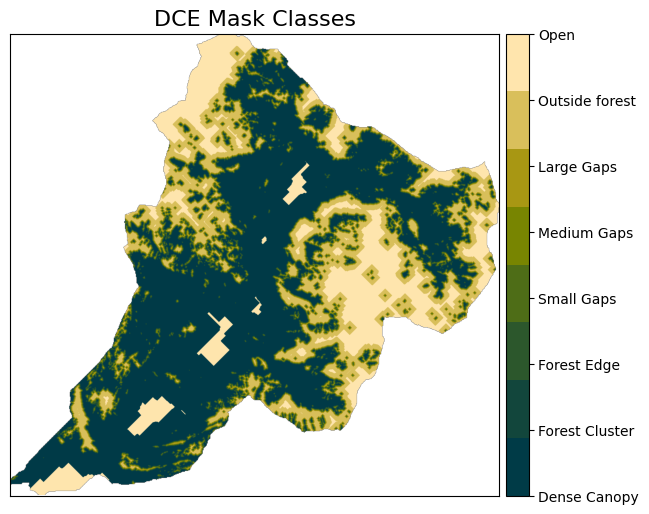

In [38]:
# plot dce_mask with cmc.bamako colormap
fig, ax = plt.subplots(figsize=(8, 6))



# categorical colorbar
import cmcrameri.cm as cmc
from matplotlib import cm
from matplotlib.colors import ListedColormap

unique_values = np.unique(dce_groups.values[~np.isnan(dce_groups.values)])  # Exclude NaN values
colors = [cmc.bamako(i / max(1, (len(unique_values) - 1))) for i in range(len(unique_values))]
labels = ['Dense Canopy', 'Forest Cluster', 'Forest Edge', 'Small Gaps', 'Medium Gaps', 'Large Gaps', 'Outside forest', 'Open']
cmap = ListedColormap(colors)
im = plt.imshow(dce_groups.values[0], cmap=cmap, vmin=-1, vmax=6)

cbar = fig.colorbar(im, ax=ax, pad=0.01)
cbar.ax.set_yticklabels(labels)

plt.title('DCE Mask Classes', fontsize=16)
plt.xticks([])
plt.yticks([])
plt.show()

In [144]:
# Print basic stats for DCE
print("DCE min:", np.nanmin(dce.values))
print("DCE max:", np.nanmax(dce.values))

# Check range of DCE values in open areas
open_mask = (basin_mask.values == 1)  # assuming chm_mask == 1 means open
open_dce_values = dce.values[open_mask]

print("Open DCE stats:")
print("Min:", np.nanmin(open_dce_values))
print("Max:", np.nanmax(open_dce_values))
print("Mean:", np.nanmean(open_dce_values))

DCE min: -498.0
DCE max: 98.0
Open DCE stats:
Min: -69.0
Max: 98.0
Mean: 8.14038853542529


In [39]:
# /home/etboud/projects/data/temp/BUDD/M1/20200421_163154_SCA.tif
# /home/etboud/projects/data/temp/COPP/base/20220406_175117_SCA.tif
# /home/etboud/projects/data/temp/DLNY/base/20220405_174728_SCA.tif
temp = rxr.open_rasterio('/data0/images/planet/emma/planet/raw_snow_maps/COPP/base/20220406_175117_SCA.tif').rio.clip(basin.geometry.values, all_touched = False,  drop=True)
temp.values = dce_groups.values


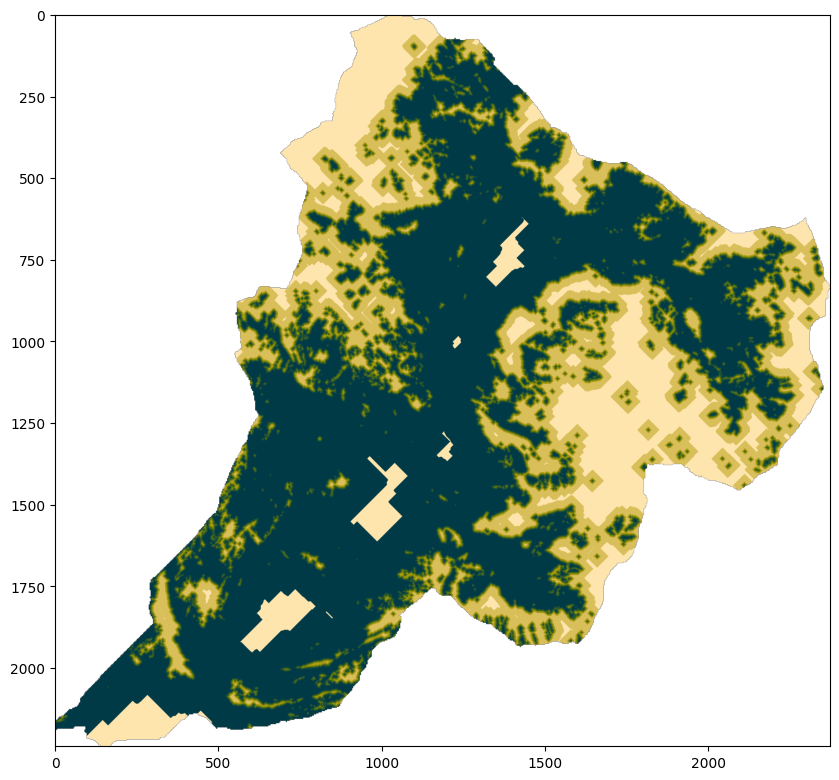

In [40]:
# plot temp
plt.figure(figsize=(10, 10))
plt.imshow(temp.squeeze(), cmap=cmap)

In [41]:
temp.rio.to_raster('/home/etboud/projects/data/masks/dce_classes_COPP.tif', driver='GTiff', dtype='float32', nodata=np.nan)